In [41]:
#mkdir /content/tmp
#%cp -r -f -v /content/drive/MyDrive/SUMONBDT /content/tmp
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/SUMONBDT
#%cd /home/liuli/github/SUMONBDT
#!nvidia-smi
#用于测试oneHot
#############################################################也是第一步，读取数据
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())



enc = OneHotEncoder()
#[2,3,5,9]
x1 = [0,0,0,0]
x2 = [0,0,0,1]

x3 = [1,1,1,2]
x4 = [1,1,1,3]
x5 = [1,1,2,4]
x6 = [1,1,2,5]
x7 = [1,2,3,6]
x8 = [1,2,3,7]
x9 = [1,2,4,8]
X = [x1, x2, x3,x4,x5,x6,x7,x8,x9]
enc.fit(X)
#print(enc.transform(X).toarray())


########################读写CSV,并转为oneHot
file1 = "./trainData/dataAllSim1000.csv"
print("reading data")
xyDataTmp = pd.read_csv(file1)
#print(xyDataTmp.info())
xyData = np.array(xyDataTmp)

x = xyData[:,0:22]
y = xyData[:,22:26]
ylabel = y
y = enc.transform(y).toarray()

print("x.shape:",x.shape,"yOneHot.shape:",y.shape)



del xyDataTmp #节省内存
del xyData #节省内存



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11186583059525556937
]
reading data
x.shape: (844538, 22) yOneHot.shape: (844538, 19)


In [ ]:

################################################################第二步，训练
#1. 核心为keras220不是pytorch
#2. 基于hmcnf
import model_hmcnf
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

#os.environ["CUDA_VISIBLE_DEVICES"]="0"

#hierarchy = [18, 80, 178, 142, 77, 4]
hierarchy = [2,3,5,9]
features_size = x.shape[1]
label_size = y.shape[1]
beta = 0.2
dropout_rate=0.1
relu_size=384



def local_model(num_labels, dropout_rate, relu_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(relu_size, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_labels, activation='sigmoid'))
    return model


def global_model(dropout_rate, relu_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(relu_size, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    return model


def sigmoid_model(label_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(label_size, activation='sigmoid',name="global"))
    return model

features = layers.Input(shape=(features_size,))
global_models = []
local_models = []


for i in range(len(hierarchy)):
    if i == 0:
        global_models.append(global_model(dropout_rate, relu_size)(features))
    else:
        global_models.append(global_model(dropout_rate, relu_size)(layers.concatenate([global_models[i-1], features])))

p_glob = sigmoid_model(label_size)(global_models[-1])


#显示只有全局模型的情况
#modelTmp1 = tf.keras.Model(inputs=[features], outputs=[p_glob])
#modelTmp1.summary()#
#plot_model(modelTmp1, to_file='Flatten1.png', show_shapes=True)


for i in range(len(hierarchy)):
    local_models.append(local_model(hierarchy[i], dropout_rate, relu_size)(global_models[i]))
    
#显示只有局部局模型的情况(部分全局)
p_loc = layers.concatenate(local_models)
#modelTmp2 = tf.keras.Model(inputs=[features], outputs=[p_loc])
#modelTmp2.summary()#
#plot_model(modelTmp2, to_file='Flatten2.png', show_shapes=True)
p_glob1 = layers.Lambda(lambda x: x*beta,name="global")(p_glob)
p_loc1 = layers.Lambda(lambda x: x*(1-beta),name="local")(p_loc)

labels = layers.add([p_glob1, p_loc1])

model = tf.keras.Model(inputs=[features], outputs=[labels])




plot_model(model, to_file='FlattenAll.png', show_shapes=True)


model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['mae'])
model.fit([x],[y],epochs=1000, batch_size=25600*1)
model.save("hmcnf10000.h5")

In [ ]:
##################################################################第三步，验证
#%cd /content/drive/MyDrive/SUMONBDT
import model_hmcnf
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import numpy as np
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#######################0.准备onehot
enc = OneHotEncoder()
#[2,3,5,9]
x1 = [0,0,0,0]
x2 = [0,0,0,1]

x3 = [1,1,1,2]
x4 = [1,1,1,3]
x5 = [1,1,2,4]
x6 = [1,1,2,5]
x7 = [1,2,3,6]
x8 = [1,2,3,7]
x9 = [1,2,4,8]
X = [x1, x2, x3,x4,x5,x6,x7,x8,x9]
enc.fit(X)

#######################2.准备数据
        
file1 = "./trainData/dataAllSim10000.csv"
file1 = "./trainData/dataAllSim.csv"
print("reading data")
xyDataTmp = pd.read_csv(file1)
#print(xyDataTmp.info())
xyData = np.array(xyDataTmp)

x = xyData[:,0:22]
y = xyData[:,22:26]
ylabel = y
y = enc.transform(y).toarray()


del xyDataTmp #节省内存
del xyData #节省内存
#######################3.预测模型
print("3.HMCNF预测模型")
hierarchy = [2,3,5,9]
features_size = x.shape[1]
label_size = y.shape[1]
beta = 0.2

model_name ="hmcnf.h5" 

model = keras.models.load_model(model_name)
y_out = model.predict([x], batch_size=2560)
y_predict = np.where(y_out > 0.5, 1, 0)

predict_ok = np.where(np.sum(y_predict - y, axis=1) == 0, 1, 0)


print("validated {} , {} good out of {} samples".format(model_name, np.sum(predict_ok), predict_ok.shape[0]))
del y_predict #节省内存
del predict_ok #节省内存
#######################3.层次预测预测模型
print("3.层次预测预测模型")
y1 = np.where(y_out[:,0:2] > 0.5, 1, 0)
y2 = np.where(y_out[:,2:5] > 0.5, 1, 0)
y3 = np.where(y_out[:,5:10] > 0.5, 1, 0)
y4 = np.where(y_out[:,10:19] > 0.5, 1, 0)
for i in range(y4.shape[0]):
    tmp1 = y1[i]
    tmp2 = y2[i]
    tmp3 = y3[i]
    tmp4 = y4[i]
    if sum(tmp1) == 0:
        index=  np.argmax(tmp1)
        y1[i,index]=1
        
    if sum(tmp2) == 0:
        index=  np.argmax(tmp2)
        y2[i,index]=1
        
    if sum(tmp3) == 0:
        index=  np.argmax(tmp3)
        y3[i,index]=1
    
    if sum(tmp4) == 0:
        index=  np.argmax(tmp4)
        y4[i,index]=1
        #print(i,y4[i],index)
y_predict = np.concatenate([y1,y2,y3,y4],axis=1)
predict_ok = np.where(np.sum(y_predict - y, axis=1) == 0, 1, 0)
print("validated {} , {} good out of {} samples".format(model_name, np.sum(predict_ok), predict_ok.shape[0]))

#onehot 2 label
ypredict = enc.inverse_transform(y_predict)
del y_predict #节省内存
del predict_ok #节省内存
del y1,y2,y3,y4
#######################4.评估层次模型
#hierarchy = [2,3,5,9]

##第一层，2
print("###################################第一层，2")
h1_yp = ypredict[:,0]
h1_yl = ylabel[:,0]
tmp1 = classification_report(h1_yl,h1_yp)
tmp2 = confusion_matrix(h1_yl,h1_yp,normalize='true')
tmp3 = confusion_matrix(h1_yl,h1_yp,normalize='pred')
print(tmp1)
print(np.around(tmp2, decimals=3))
print(np.around(tmp3, decimals=3))


##第二层，3
print("################################第二层，3")
h2_yp = ypredict[:,1]
h2_yl = ylabel[:,1]
tmp1 = classification_report(h2_yl,h2_yp)
tmp2 = confusion_matrix(h2_yl,h2_yp,normalize='true')
tmp3 = confusion_matrix(h2_yl,h2_yp,normalize='pred')
print(tmp1)
print(np.around(tmp2, decimals=3))
print(np.around(tmp3, decimals=3))



##第三层，5
print("#############################第三层，5")
h3_yp = ypredict[:,2]
h3_yl = ylabel[:,2]
tmp1 = classification_report(h3_yl,h3_yp)
tmp2 = confusion_matrix(h3_yl,h3_yp,normalize='true')
tmp3 = confusion_matrix(h3_yl,h3_yp,normalize='pred')
print(tmp1)
print(np.around(tmp2, decimals=3))
print(np.around(tmp3, decimals=3))


##第四层，9
print("#############################第四层，9")
h4_yp = ypredict[:,3]
h4_yl = ylabel[:,3]
tmp1 = classification_report(h4_yl,h4_yp)
tmp2 = confusion_matrix(h4_yl,h4_yp,normalize='true')
tmp3 = confusion_matrix(h4_yl,h4_yp,normalize='pred')
print(tmp1)
print(np.around(tmp2, decimals=3))
print(np.around(tmp3, decimals=3))



In [ ]:
#第四步，根据混淆矩阵进行聚类。第一列代表识别为类别1的样本真实的类别分布
import numpy as np
import copy
#########################################手动准备模拟数据
mat1 = np.array([[0.952,0.004,0.015,0.008],
 [0.018,0.923,0.016,0.032],
 [0.016,0.036,0.934,0.047],
 [0.014,0.037,0.035,0.913]])
accy = [mat1[0,0],mat1[1,1],mat1[2,2],mat1[3,3]]
print("accuracy",accy)
matT1 = mat1
mat1[:,0] = matT1[:,0]*1000
mat1[:,1] = matT1[:,1]*1000
mat1[:,2] = matT1[:,2]*1000
mat1[:,3] = matT1[:,3]*1000
sumTmp =  sum(mat1)
print(sumTmp)
print(mat1)

##########################################计算最佳合并位置，根据最大的正确率提高
def computeAccuracyDiff(mat1,accy):
    h,w = mat1.shape
    tmp = np.zeros((h-1,w-1))
    matTmp={}
    ##从0到最后，行列合并
    for index in range(h-1):

        tmp = np.zeros((h-1,w))
        num = 0
        ####行合并
        for i in range(h):#行合并
            if i == index:
                tmp[num]=mat1[i]+mat1[i+1]
                num=num+1
                continue
            if i== index+1:
                continue

            tmp[num]=mat1[i]
            num=num+1

        ####列合并   
        mat2=tmp
        tmp = np.zeros((h-1,w-1))
        num = 0
        for j in range(w):#列合并
            if j == index:
                tmp[:,num] = mat2[:,j]+mat2[:,j+1]
                num=num+1
                continue
            if j== index+1:
                continue

            tmp[:,num] = mat2[:,j]
            num=num+1
        matTmp[index] = tmp
        
        #print("合并后的所有矩阵")
        #print(index,matTmp[index])#合并后的所有矩阵
    matTmp1 = copy.deepcopy(matTmp)
   
    ##归一化   
    maxDiffMat = np.zeros((len(matTmp),1))
    for i in range(len(matTmp)):
        tmp = matTmp[i]
        sumTmp =  sum(tmp)
        for j in range(tmp.shape[1]):
            tmp[:,j] = tmp[:,j]/(sumTmp[j])

        accyNow = tmp[i,i]
        maxDiffMat[i]= max(accyNow-accy[i],accyNow-accy[i+1])
    maxIndex = np.argmax(maxDiffMat)
    maxDiff = max(maxDiffMat)
    #print(matTmp1)
    return maxIndex,maxDiff,maxDiffMat,matTmp,matTmp1

#为了思考，不用for循环，直接一步一步做
#4到3
maxIndex,maxDiff,maxDiffMat,matTmp,matTmp1 =computeAccuracyDiff(mat1,accy)
chosedMat =  matTmp1[maxIndex]
print("最佳合并点和矩阵",maxIndex,maxDiff)
print(matTmp1[maxIndex])

#3到2
mat3to2=matTmp1[maxIndex]
accy3to2 = [matTmp[maxIndex][0,0],matTmp[maxIndex][1,1],matTmp[maxIndex][2,2]]
maxIndex3to2,maxDiff3to2,maxDiffMat3to2,matTmp3to2,matTmp3to2Origin =computeAccuracyDiff(mat3to2,accy3to2)
chosedMat = matTmp3to2Origin[maxIndex3to2]
print("最佳合并点和矩阵",maxIndex3to2,maxDiff3to2)
print(matTmp3to2Origin[maxIndex3to2])
print(matTmp3to2[maxIndex3to2])


#########################################采用数据进行分析
print("\n\n\n###################################################")
print("\n\n\n 用第5层数据进行分析")
h3_yp = ypredict[:,2]
h3_yl = ylabel[:,2]
mat1 = confusion_matrix(h3_yl,h3_yp)
p1 = confusion_matrix(h3_yl,h3_yp,normalize='pred')
sumTmp = sum(mat1)
print(mat1)
print(sumTmp)
print(np.around(p1, decimals=3))

########5->4
accy = [p1[0,0],p1[1,1],p1[2,2],p1[3,3],p1[4,4]]
maxIndex,maxDiff,maxDiffMat,matTmp,matTmp1 =computeAccuracyDiff(mat1,accy)
chosedMat =  matTmp1[maxIndex]
print("\n\n\n5->4,最佳合并点和矩阵",maxIndex,maxDiff)
print(matTmp1[maxIndex])
print(np.around(matTmp[maxIndex], decimals=3))

########4->3
mat1=matTmp1[maxIndex]
accy= [matTmp[maxIndex][0,0],matTmp[maxIndex][1,1],matTmp[maxIndex][2,2],matTmp[maxIndex][3,3]]

maxIndex,maxDiff,maxDiffMat,matTmp,matTmp1 =computeAccuracyDiff(mat1,accy)
chosedMat =  matTmp1[maxIndex]
print("\n\n\n4->3,最佳合并点和矩阵",maxIndex,maxDiff)
print(matTmp1[maxIndex])
print(np.around(matTmp[maxIndex], decimals=3))


########3->2
mat1=matTmp1[maxIndex]
accy= [matTmp[maxIndex][0,0],matTmp[maxIndex][1,1],matTmp[maxIndex][2,2]]

maxIndex,maxDiff,maxDiffMat,matTmp,matTmp1 =computeAccuracyDiff(mat1,accy)
chosedMat =  matTmp1[maxIndex]
print("\n\n\n3->2,最佳合并点和矩阵",maxIndex,maxDiff)
print(matTmp1[maxIndex])
print(np.around(matTmp[maxIndex], decimals=3))

In [ ]:
##测试最简注意力机制，Attention Channel ,SEAttention
import pandas as pd
import numpy as np
from keras.utils.vis_utils import plot_model
np.random.seed(1337)  # for reproducibility
 
from keras.models import *
from keras.layers import Input, Dense,Multiply,Activation
 
input_dim = 4


def get_data(n, input_dim, attention_column=1):

    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y

 
 
def Att(att_dim,inputs,name):
    V = inputs
    QK = Dense(att_dim,bias=None)(inputs)
    QK = Activation("softmax",name=name)(QK)
    MV = Multiply()([V, QK])
    return(MV)
 
 
def build_model():
    inputs = Input(shape=(input_dim,))
 
    atts1 = Att(input_dim,inputs,"attention_vec")
 
    x = Dense(16)(atts1)
    atts2 = Att(16,x,"attention_vec1")
 
 
    output = Dense(1, activation='sigmoid')(atts2)
    model = Model(input=inputs, output=output)
    return model

N = 10000
inputs_1, outputs = get_data(N, input_dim) 
print(inputs_1)
 
m = build_model()
plot_model(m, to_file='attMap.png', show_shapes=True)
#m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#print(m.summary())
#m.fit(inputs_1, outputs, epochs=20, batch_size=128, validation_split=0.2)testing_inputs_1, testing_outputs = get_data(1, input_dim)


#原文链接：https://blog.csdn.net/xiaosongshine/article/details/90579679

In [ ]:
#https://blog.csdn.net/SKIp121whats112/article/details/122265766
#https://scikit-learn.org/stable/modules/tree.html
##############测试决策树
from sklearn import tree
import graphviz 
Input= x
Output = ylabel[:,2]
print(x)
print(Output)
dt = tree.DecisionTreeClassifier(max_depth=5,min_samples_split=100,min_samples_leaf=100,min_impurity_decrease=0.001)
dt = dt.fit(Input, Output)
tree.plot_tree(dt)
data=tree.export_graphviz(dt, out_file=None,class_names=['0','1','2','3','4'],filled=True) 
graph = graphviz.Source(data)
graph.render("now")

data=tree.export_graphviz(dt, out_file=None,class_names=['0','1','2','3','4'],filled=True,proportion=True) 
graph = graphviz.Source(data)
graph.render("nowPercent")

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
OutPredict = dt.predict(Input)

tmp1 = classification_report(Output,OutPredict )
tmp2 = confusion_matrix(Output,OutPredict ,normalize='true')
tmp3 = confusion_matrix(Output,OutPredict ,normalize='pred')
print(tmp1)
print(np.around(tmp2, decimals=3))
print(np.around(tmp3, decimals=3))

reading data


/home/liuli/miniconda3/envs/keras220CpuJupyter/lib/python3.6/site-packages/sklearn/tree/_classes.py:321: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  FutureWarning


              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    552177
         1.0       0.97      0.97      0.97    292361

    accuracy                           0.98    844538
   macro avg       0.98      0.98      0.98    844538
weighted avg       0.98      0.98      0.98    844538

[0.97467274 0.97467274 0.97467274]
[[1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
impurity [0.45267797 0.03445841 0.26253417 0.4934526  0.29142115 0.49429895
 0.26654665 0.2095261  0.08010767 0.19778857 0.43316507 0.14129446
 0.27361852 0.04937157 0.09183478 0.05431998 0.07252588 0.01894457
 0.29041173 0.27316328 0.09370253 0.46912764 0.26242661 0.22918635
 0.08592972 0.44825452 0.10397994 0.29191148 0.01532416]
feature [ 8 -2  0  2  0  4 -2 -2 -2  4  0 -2 -2 -2  6 -2  5 -2  0  0 -2  4 -2 -2
  0  5 -2 -2 -2]
threshold [ 8.50099993

IndexError: index 3 is out of bounds for axis 0 with size 3

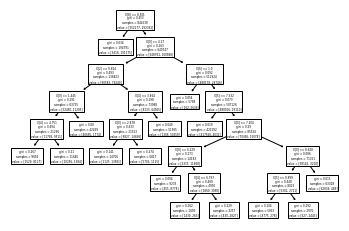

In [39]:
#测试决策树的特征
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz 
import matplotlib.pyplot as plt
###测试权重
nSamples =5000
input_dim = 10
#x = np.random.standard_normal(size=(nSamples, input_dim))
x = np.random.randint(low=0, high=10, size=(nSamples, input_dim))
y1 = np.zeros((nSamples, 1))#>50
y1A = np.zeros((nSamples, 1))#>50 and <60
y1B = np.zeros((nSamples, 1))#>=60
sumX = np.sum(x,axis=1)
index=np.where(sumX>40)
y1[index]=1
index=np.where((sumX>50)& (sumX<70))
y1A[index]=1
index=np.where(sumX>=70)
y1B[index]=1

##数据来源2
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

file1 = "./trainData/dataAllSim1000.csv"
print("reading data")
xyDataTmp = pd.read_csv(file1)
xyData = np.array(xyDataTmp)
nSamples, nDims= xyData.shape
x = xyData[:,0:22]
y = xyData[:,22:26]
ylabel = y
y1= y[:,0]


##################################################################
#测试决策树
def dtFitAndSave(x,y,class_names1,saveName):
    dt = tree.DecisionTreeClassifier(max_depth=7,min_samples_split=100,min_samples_leaf=100,min_impurity_split=0.06,ccp_alpha=0.001)
    dt = dt.fit(x, y)
    tree.plot_tree(dt)
    data=tree.export_graphviz(dt, out_file=None,class_names=class_names1,filled=True) 
    graph = graphviz.Source(data)
    graph.render(saveName)
    
    yPredict = dt.predict(x)
    tmp1 = classification_report(y,yPredict)
    print(tmp1)
    text_representation = tree.export_text(dt)
    #print(text_representation)
    #yPredict = dt.predict_proba(x)
    #index = np.where((yPredict[:,1]<0.98)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.90)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.80)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.70)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    
    yPredict = dt.predict_proba(x[0:3,:])
    print(yPredict[:,1])
    d_path = dt.decision_path(x[0:3,:]).todense()
    print(d_path)
    print("impurity",dt.tree_.impurity)
    print("feature",dt.tree_.feature)
    print("threshold",dt.tree_.threshold)
    
    #左节点编号  :  clf.tree_.children_left
    #右节点编号  :  clf.tree_.children_right
    #分割的变量  :  clf.tree_.feature
    #分割的阈值  :  clf.tree_.threshold
    #不纯度(gini) :  clf.tree_.impurity
    #样本个数      :  clf.tree_.n_node_samples
    #样本分布      :  clf.tree_.value
    #https://blog.csdn.net/ywj_1991/article/details/122985778
    #https://www.javaroad.cn/questions/54003

    w,h = d_path.shape
    for i in range(h):
       path = d_path[i]
       v,ind = np.where(path>0)
       xtmp = x[i]
       #print("path",path,ind,np.array(ind)[-1])
    
       print("\n index",index)
       print("impurity",dt.tree_.impurity[ind])
       print("feature",dt.tree_.feature[ind])
       print("threshold",dt.tree_.threshold[ind])
       print("x[index]",xtmp[ind])
       
      
       print("the leaf node:",np.array(ind)[-1],"the simplest rule is")
       for jj in ind:
           if dt.tree_.feature[jj] == -2:
                print("label,proba is",yPredict[i,0],yPredict[i,1])
                break
                
           if xtmp[jj]<=dt.tree_.threshold[jj]:
              print(" x[%d]<=%.3f" %(dt.tree_.feature[jj],dt.tree_.threshold[jj]))
           else:
              print(" x[%d]>%.3f" %(dt.tree_.feature[jj],dt.tree_.threshold[jj]))
                    
       finalPos = np.array(ind)[-1]
       print(dt.tree_.impurity[finalPos])
       print(dt.tree_.feature[finalPos])
       print(dt.tree_.threshold[finalPos])

dtFitAndSave(x,y1,["0","1"],"bigger")

###################################################################################
#测试神经网络
def kerasFitAndSave(x,y,num_labels):
    nSamples,features_size = x.shape
    relu_size = 384
    dropout_rate =0.1
    models=[]
    
    build_model = tf.keras.Sequential()
   
    build_model.add(layers.Dense(relu_size, activation='relu',name="layer1",input_shape=(features_size,)))
    build_model.add(layers.Dropout(dropout_rate,name="Dropout1-2"))
    build_model.add(layers.Dense(num_labels, activation='sigmoid',name="layer2"))
    
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    plot_model(build_model, to_file='AKeras.png', show_shapes=True)
    
    enc = OneHotEncoder()
    enc.fit(y)  
    yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    build_model.fit([x],[yOnehot],epochs=100, batch_size=80000*1)
    build_model.save("Akeras.h5")
    plot_model(build_model, to_file='AKeras.png', show_shapes=True)
    
    return build_model,models

def kerasFitAndSaveSimple(x,y,num_labels):
    nSamples,features_size = x.shape
    relu_size = 382
    models=[]
    
    build_model = tf.keras.Sequential()
    build_model.add(layers.Dense(relu_size, activation='relu'))
    build_model.add(layers.Dropout(dropout_rate))
    build_model.add(layers.Dense(num_labels, activation='sigmoid'))
    build_model.add(layers.Dense(num_labels, activation='sigmoid',name="layer1",input_shape=(features_size,)))
    
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    plot_model(build_model, to_file='AKerasSimple.png', show_shapes=True)
    
    enc = OneHotEncoder()
    enc.fit(y)  
    yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    build_model.fit([x],[yOnehot],epochs=10000, batch_size=80000*1)
    build_model.save("Akeras.h5")
    plot_model(build_model, to_file='AKeras.png', show_shapes=True)
    
    return build_model,models

y1 = np.array(y1)
y1= y1.reshape(nSamples,-1)
print(y1)
#kerasFitAndSave(x,y1,2)
#kerasFitAndSaveSimple(x,y1,2)

In [42]:
########################################融合决策树和多层神经网络###########################################################

#######################################第一步读取数据
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

file1 = "./trainData/dataAllSim1000.csv"
print("reading data")
xyDataTmp = pd.read_csv(file1)
xyData = np.array(xyDataTmp)
nSamples, nDims= xyData.shape
x = xyData[:,0:22]
y = xyData[:,22:26]
ylabel = y
y1Level= y[:,0]#01
y2Level= y[:,1]#012
y3Level= y[:,2]#01234

print("x.shape:",x.shape,"y.shape:",y.shape)

del xyDataTmp #节省内存
del xyData #节省内存

reading data
x.shape: (844538, 22) y.shape: (844538, 4)


In [ ]:
########################################融合决策树和多层神经网络###########################################################

#######################################第二步基于神经网络训练，这里采用简单神经网络，RESNET类似和HNCF三种方法进行训练
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
###简单模型1，没有隐藏层
def kerasFitAndSaveSimple1(x,yOneHot,num_labels):
    nSamples,features_size = x.shape
    build_model = tf.keras.Sequential()
    build_model.add(layers.Dense(num_labels, activation='sigmoid',name="layer1",input_shape=(features_size,)))
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    
    #enc = OneHotEncoder()
    #enc.fit(y)  
    #yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    build_model.fit([x],[yOneHot],epochs=10000, batch_size=80000*1)
    build_model.save("kerasSimple1.h5")
    plot_model(build_model, to_file='KerasSimple1_noHiddenLayer.png', show_shapes=True)
    return build_model

###简单模型2，有隐藏层
def kerasFitAndSaveSimple2(x,yOneHot,num_labels):
    nSamples,features_size = x.shape
    relu_size = 512
    dropout_rate = 0.05
    build_model = tf.keras.Sequential()
    build_model.add(layers.Dense(relu_size, activation='relu',name="layer1",input_shape=(features_size,)))
    build_model.add(layers.Dropout(dropout_rate,name="Dropout1-2"))
    build_model.add(layers.Dense(relu_size/2, activation='relu',name="layer2"))
    build_model.add(layers.Dropout(dropout_rate,name="Dropout2-3"))
    build_model.add(layers.Dense(num_labels, activation='sigmoid',name="layer3"))
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    #enc = OneHotEncoder()
    #enc.fit(y)  
    #yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    build_model.fit([x],[yOneHot],epochs=10000, batch_size=80000*1)
    build_model.save("kerasSimple2.h5")
    plot_model(build_model, to_file='KerasSimple2_HiddenLayer.png', show_shapes=True)
    return build_model

###简单模型3，resnet_like
def global_model(dropout_rate, relu_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(relu_size, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    return model

def sigmoid_model(label_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(label_size, activation='sigmoid',name="global"))
    return model

def kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels):
    nSamples,features_size = x.shape
    relu_size = 512
    dropout_rate = 0.05
    hierarchy = [1,1,1]
    global_models = []
    features = layers.Input(shape=(features_size,))
    for i in range(len(hierarchy)):
        if i == 0:
            global_models.append(global_model(dropout_rate, relu_size)(features))
        else:
            global_models.append(global_model(dropout_rate, relu_size)(layers.concatenate([global_models[i-1], features])))

    p_glob = sigmoid_model(label_size)(global_models[-1])
    build_model = tf.keras.Model(inputs=[features], outputs=[p_glob])
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    #enc = OneHotEncoder()
    #enc.fit(y)  
    #yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    build_model.fit([x],[yOneHot],epochs=10000, batch_size=80000*1)
    build_model.save("KerasSimple3_likeResnet.h5")
    plot_model(build_model, to_file='KerasSimple3_likeResnet.png', show_shapes=True)
    return build_model
    print("HMCNF is not implemented")
    return False

###开始训练
nSamples,features_size = x.shape
num_labels = 5
enc = OneHotEncoder()
y3Level = np.array(y3Level)
y3Level= y3Level.reshape(nSamples,-1)
print(y3Level)
enc.fit(y3Level)  
yOneHot=enc.transform(y3Level).toarray()
simpleMode1 = kerasFitAndSaveSimple1(x,yOneHot,num_labels)
simpleMode2 = kerasFitAndSaveSimple2(x,yOneHot,num_labels)
simpleMode3 = kerasFitAndSaveSimple3(x,yOneHot,num_labels)

[[2.]
 [2.]
 [2.]
 ...
 [0.]
 [0.]
 [0.]]
Epoch 1/10000
844538/844538 [==============================] - 2s 2us/step - loss: 3.9893 - acc: 0.5089
Epoch 2/10000
844538/844538 [==============================] - 1s 1us/step - loss: 3.5638 - acc: 0.5291
Epoch 3/10000
844538/844538 [==============================] - 1s 1us/step - loss: 3.1420 - acc: 0.5461
Epoch 4/10000
844538/844538 [==============================] - 1s 1us/step - loss: 2.7354 - acc: 0.5630
Epoch 5/10000
844538/844538 [==============================] - 1s 1us/step - loss: 2.3498 - acc: 0.5831
Epoch 6/10000
844538/844538 [==============================] - 1s 1us/step - loss: 1.9927 - acc: 0.6082
Epoch 7/10000
844538/844538 [==============================] - 1s 1us/step - loss: 1.6719 - acc: 0.6382
Epoch 8/10000
844538/844538 [==============================] - 1s 1us/step - loss: 1.3956 - acc: 0.6688
Epoch 9/10000
844538/844538 [==============================] - 1s 1us/step - loss: 1.1726 - acc: 0.6957
Epoch 10/10000
844538/

844538/844538 [==============================] - 1s 1us/step - loss: 0.2791 - acc: 0.8984
Epoch 79/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2777 - acc: 0.8992
Epoch 80/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2764 - acc: 0.8999
Epoch 81/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2751 - acc: 0.9006
Epoch 82/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2738 - acc: 0.9012
Epoch 83/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2726 - acc: 0.9019
Epoch 84/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2714 - acc: 0.9025
Epoch 85/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2702 - acc: 0.9030
Epoch 86/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2691 - acc: 0.9036
Epoch 87/10000
844538/844538 [==============================] - 1s 1us

844538/844538 [==============================] - 1s 1us/step - loss: 0.2228 - acc: 0.9130
Epoch 156/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2224 - acc: 0.9132
Epoch 157/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2220 - acc: 0.9132
Epoch 158/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2215 - acc: 0.9134
Epoch 159/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2211 - acc: 0.9134
Epoch 160/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2207 - acc: 0.9135
Epoch 161/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2204 - acc: 0.9137
Epoch 162/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2200 - acc: 0.9137
Epoch 163/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2196 - acc: 0.9138
Epoch 164/10000
844538/844538 [==============================]

844538/844538 [==============================] - 1s 1us/step - loss: 0.2044 - acc: 0.9195
Epoch 233/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2043 - acc: 0.9197
Epoch 234/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2042 - acc: 0.9195
Epoch 235/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2040 - acc: 0.9197
Epoch 236/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2039 - acc: 0.9198
Epoch 237/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2038 - acc: 0.9198
Epoch 238/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2037 - acc: 0.9200
Epoch 239/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2036 - acc: 0.9199
Epoch 240/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.2034 - acc: 0.9200
Epoch 241/10000
844538/844538 [==============================]

844538/844538 [==============================] - 1s 1us/step - loss: 0.1972 - acc: 0.9222
Epoch 310/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1972 - acc: 0.9223
Epoch 311/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1971 - acc: 0.9223
Epoch 312/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1970 - acc: 0.9223
Epoch 313/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1970 - acc: 0.9224
Epoch 314/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1969 - acc: 0.9224
Epoch 315/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1968 - acc: 0.9223
Epoch 316/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1968 - acc: 0.9225
Epoch 317/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1967 - acc: 0.9224
Epoch 318/10000
844538/844538 [==============================]

844538/844538 [==============================] - 1s 1us/step - loss: 0.1928 - acc: 0.9237
Epoch 387/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1927 - acc: 0.9237
Epoch 388/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1927 - acc: 0.9237
Epoch 389/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1926 - acc: 0.9237
Epoch 390/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1926 - acc: 0.9237
Epoch 391/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1925 - acc: 0.9238
Epoch 392/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1925 - acc: 0.9238
Epoch 393/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1924 - acc: 0.9237
Epoch 394/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1924 - acc: 0.9238
Epoch 395/10000
844538/844538 [==============================]

844538/844538 [==============================] - 1s 1us/step - loss: 0.1895 - acc: 0.9244
Epoch 464/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1895 - acc: 0.9245
Epoch 465/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1895 - acc: 0.9245
Epoch 466/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1894 - acc: 0.9244
Epoch 467/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1894 - acc: 0.9245
Epoch 468/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1894 - acc: 0.9245
Epoch 469/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1893 - acc: 0.9245
Epoch 470/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1893 - acc: 0.9246
Epoch 471/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1892 - acc: 0.9245
Epoch 472/10000
844538/844538 [==============================]

844538/844538 [==============================] - 1s 1us/step - loss: 0.1871 - acc: 0.9252
Epoch 541/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1870 - acc: 0.9251
Epoch 542/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1870 - acc: 0.9252
Epoch 543/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1870 - acc: 0.9251
Epoch 544/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1870 - acc: 0.9252
Epoch 545/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1869 - acc: 0.9252
Epoch 546/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1869 - acc: 0.9252
Epoch 547/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1869 - acc: 0.9252
Epoch 548/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1869 - acc: 0.9252
Epoch 549/10000
844538/844538 [==============================]

844538/844538 [==============================] - 1s 1us/step - loss: 0.1851 - acc: 0.9258
Epoch 618/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1851 - acc: 0.9258
Epoch 619/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1851 - acc: 0.9259
Epoch 620/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1850 - acc: 0.9260
Epoch 621/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1850 - acc: 0.9259
Epoch 622/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1850 - acc: 0.9259
Epoch 623/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1850 - acc: 0.9259
Epoch 624/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1849 - acc: 0.9260
Epoch 625/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1849 - acc: 0.9259
Epoch 626/10000
844538/844538 [==============================]

844538/844538 [==============================] - 1s 1us/step - loss: 0.1834 - acc: 0.9268
Epoch 695/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1834 - acc: 0.9269
Epoch 696/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1834 - acc: 0.9268
Epoch 697/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1834 - acc: 0.9268
Epoch 698/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1834 - acc: 0.9269
Epoch 699/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1833 - acc: 0.9269
Epoch 700/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1833 - acc: 0.9269
Epoch 701/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1833 - acc: 0.9269
Epoch 702/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1833 - acc: 0.9269
Epoch 703/10000
844538/844538 [==============================]

844538/844538 [==============================] - 1s 1us/step - loss: 0.1820 - acc: 0.9279
Epoch 772/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1820 - acc: 0.9278
Epoch 773/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1820 - acc: 0.9280
Epoch 774/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1819 - acc: 0.9279
Epoch 775/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1819 - acc: 0.9279
Epoch 776/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1819 - acc: 0.9280
Epoch 777/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1819 - acc: 0.9280
Epoch 778/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1819 - acc: 0.9280
Epoch 779/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1819 - acc: 0.9280
Epoch 780/10000
844538/844538 [==============================]

844538/844538 [==============================] - 1s 1us/step - loss: 0.1808 - acc: 0.9288
Epoch 849/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1808 - acc: 0.9288
Epoch 850/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1807 - acc: 0.9288
Epoch 851/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1807 - acc: 0.9288
Epoch 852/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1807 - acc: 0.9288
Epoch 853/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1807 - acc: 0.9289
Epoch 854/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1807 - acc: 0.9288
Epoch 855/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1807 - acc: 0.9289
Epoch 856/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1806 - acc: 0.9289
Epoch 857/10000
844538/844538 [==============================]

844538/844538 [==============================] - 1s 1us/step - loss: 0.1797 - acc: 0.9296
Epoch 926/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1797 - acc: 0.9297
Epoch 927/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1797 - acc: 0.9297
Epoch 928/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1796 - acc: 0.9296
Epoch 929/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1796 - acc: 0.9297
Epoch 930/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1796 - acc: 0.9297
Epoch 931/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1796 - acc: 0.9297
Epoch 932/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1796 - acc: 0.9298
Epoch 933/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1796 - acc: 0.9296
Epoch 934/10000
844538/844538 [==============================]

844538/844538 [==============================] - 1s 1us/step - loss: 0.1787 - acc: 0.9304
Epoch 1003/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1787 - acc: 0.9303
Epoch 1004/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1787 - acc: 0.9304
Epoch 1005/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1787 - acc: 0.9303
Epoch 1006/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1787 - acc: 0.9304
Epoch 1007/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1787 - acc: 0.9304
Epoch 1008/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1787 - acc: 0.9304
Epoch 1009/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1787 - acc: 0.9304
Epoch 1010/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1786 - acc: 0.9303
Epoch 1011/10000
844538/844538 [======================

844538/844538 [==============================] - 1s 1us/step - loss: 0.1779 - acc: 0.9308
Epoch 1079/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1779 - acc: 0.9310
Epoch 1080/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1779 - acc: 0.9309
Epoch 1081/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1779 - acc: 0.9310
Epoch 1082/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1779 - acc: 0.9309
Epoch 1083/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1779 - acc: 0.9309
Epoch 1084/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1778 - acc: 0.9309
Epoch 1085/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1778 - acc: 0.9309
Epoch 1086/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1778 - acc: 0.9310
Epoch 1087/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1772 - acc: 0.9314
Epoch 1155/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1772 - acc: 0.9313
Epoch 1156/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1771 - acc: 0.9314
Epoch 1157/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1771 - acc: 0.9314
Epoch 1158/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1771 - acc: 0.9314
Epoch 1159/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1771 - acc: 0.9315
Epoch 1160/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1771 - acc: 0.9314
Epoch 1161/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1771 - acc: 0.9315
Epoch 1162/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1771 - acc: 0.9314
Epoch 1163/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1765 - acc: 0.9319
Epoch 1231/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1765 - acc: 0.9319
Epoch 1232/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1765 - acc: 0.9318
Epoch 1233/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1765 - acc: 0.9318
Epoch 1234/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1764 - acc: 0.9319
Epoch 1235/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1764 - acc: 0.9319
Epoch 1236/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1764 - acc: 0.9319
Epoch 1237/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1764 - acc: 0.9319
Epoch 1238/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1764 - acc: 0.9319
Epoch 1239/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1759 - acc: 0.9322
Epoch 1307/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1758 - acc: 0.9322
Epoch 1308/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1758 - acc: 0.9322
Epoch 1309/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1758 - acc: 0.9322
Epoch 1310/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1758 - acc: 0.9323
Epoch 1311/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1758 - acc: 0.9322
Epoch 1312/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1758 - acc: 0.9323
Epoch 1313/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1758 - acc: 0.9323
Epoch 1314/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1758 - acc: 0.9323
Epoch 1315/10000
844538/844538 [======================

844538/844538 [==============================] - 1s 1us/step - loss: 0.1753 - acc: 0.9326
Epoch 1383/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1753 - acc: 0.9326
Epoch 1384/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1753 - acc: 0.9326
Epoch 1385/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1753 - acc: 0.9326
Epoch 1386/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1753 - acc: 0.9327
Epoch 1387/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1753 - acc: 0.9327
Epoch 1388/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1752 - acc: 0.9326
Epoch 1389/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1752 - acc: 0.9327
Epoch 1390/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1752 - acc: 0.9326
Epoch 1391/10000
844538/844538 [======================

844538/844538 [==============================] - 1s 2us/step - loss: 0.1748 - acc: 0.9330
Epoch 1459/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1748 - acc: 0.9330
Epoch 1460/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1748 - acc: 0.9329
Epoch 1461/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1748 - acc: 0.9330
Epoch 1462/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1747 - acc: 0.9329
Epoch 1463/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1747 - acc: 0.9330
Epoch 1464/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1747 - acc: 0.9330
Epoch 1465/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1747 - acc: 0.9330
Epoch 1466/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1747 - acc: 0.9330
Epoch 1467/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1743 - acc: 0.9332
Epoch 1535/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1743 - acc: 0.9332
Epoch 1536/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1743 - acc: 0.9333
Epoch 1537/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1743 - acc: 0.9332
Epoch 1538/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1743 - acc: 0.9332
Epoch 1539/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1743 - acc: 0.9333
Epoch 1540/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1743 - acc: 0.9332
Epoch 1541/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1743 - acc: 0.9333
Epoch 1542/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1742 - acc: 0.9333
Epoch 1543/10000
844538/844538 [======================

844538/844538 [==============================] - 1s 2us/step - loss: 0.1738 - acc: 0.9334
Epoch 1611/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1738 - acc: 0.9335
Epoch 1612/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1738 - acc: 0.9335
Epoch 1613/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1738 - acc: 0.9334
Epoch 1614/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1738 - acc: 0.9334
Epoch 1615/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1738 - acc: 0.9335
Epoch 1616/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1738 - acc: 0.9335
Epoch 1617/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1738 - acc: 0.9335
Epoch 1618/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1738 - acc: 0.9335
Epoch 1619/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1734 - acc: 0.9336
Epoch 1687/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1734 - acc: 0.9337
Epoch 1688/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1734 - acc: 0.9337
Epoch 1689/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1734 - acc: 0.9336
Epoch 1690/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1734 - acc: 0.9338
Epoch 1691/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1734 - acc: 0.9337
Epoch 1692/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1734 - acc: 0.9337
Epoch 1693/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1734 - acc: 0.9337
Epoch 1694/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1734 - acc: 0.9337
Epoch 1695/10000
844538/844538 [======================

844538/844538 [==============================] - 1s 2us/step - loss: 0.1731 - acc: 0.9338
Epoch 1763/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1731 - acc: 0.9338
Epoch 1764/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1730 - acc: 0.9339
Epoch 1765/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1730 - acc: 0.9339
Epoch 1766/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1730 - acc: 0.9339
Epoch 1767/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1730 - acc: 0.9339
Epoch 1768/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1730 - acc: 0.9339
Epoch 1769/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1730 - acc: 0.9338
Epoch 1770/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1730 - acc: 0.9338
Epoch 1771/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1727 - acc: 0.9340
Epoch 1839/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1727 - acc: 0.9340
Epoch 1840/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1727 - acc: 0.9341
Epoch 1841/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1727 - acc: 0.9340
Epoch 1842/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1727 - acc: 0.9340
Epoch 1843/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1727 - acc: 0.9340
Epoch 1844/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1727 - acc: 0.9340
Epoch 1845/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1727 - acc: 0.9341
Epoch 1846/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1727 - acc: 0.9340
Epoch 1847/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1724 - acc: 0.9342
Epoch 1915/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1724 - acc: 0.9342
Epoch 1916/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1724 - acc: 0.9342
Epoch 1917/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1724 - acc: 0.9342
Epoch 1918/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1723 - acc: 0.9343
Epoch 1919/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1723 - acc: 0.9342
Epoch 1920/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1723 - acc: 0.9342
Epoch 1921/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1723 - acc: 0.9342
Epoch 1922/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1723 - acc: 0.9343
Epoch 1923/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1721 - acc: 0.9344
Epoch 1991/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1720 - acc: 0.9344
Epoch 1992/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1720 - acc: 0.9344
Epoch 1993/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1720 - acc: 0.9344
Epoch 1994/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1720 - acc: 0.9344
Epoch 1995/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1720 - acc: 0.9344
Epoch 1996/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1720 - acc: 0.9345
Epoch 1997/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1720 - acc: 0.9344
Epoch 1998/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1720 - acc: 0.9344
Epoch 1999/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1718 - acc: 0.9345
Epoch 2067/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1718 - acc: 0.9346
Epoch 2068/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1718 - acc: 0.9346
Epoch 2069/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1718 - acc: 0.9346
Epoch 2070/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1717 - acc: 0.9345
Epoch 2071/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1717 - acc: 0.9346
Epoch 2072/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1717 - acc: 0.9346
Epoch 2073/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1717 - acc: 0.9346
Epoch 2074/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1717 - acc: 0.9346
Epoch 2075/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1715 - acc: 0.9348
Epoch 2143/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1715 - acc: 0.9348
Epoch 2144/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1715 - acc: 0.9347
Epoch 2145/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1715 - acc: 0.9347
Epoch 2146/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1715 - acc: 0.9348
Epoch 2147/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1715 - acc: 0.9348
Epoch 2148/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1715 - acc: 0.9348
Epoch 2149/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1715 - acc: 0.9348
Epoch 2150/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1715 - acc: 0.9348
Epoch 2151/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1712 - acc: 0.9349
Epoch 2219/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1712 - acc: 0.9349
Epoch 2220/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1712 - acc: 0.9349
Epoch 2221/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1712 - acc: 0.9349
Epoch 2222/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1712 - acc: 0.9349
Epoch 2223/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1712 - acc: 0.9349
Epoch 2224/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1712 - acc: 0.9349
Epoch 2225/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1712 - acc: 0.9349
Epoch 2226/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1712 - acc: 0.9349
Epoch 2227/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1710 - acc: 0.9351
Epoch 2295/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1710 - acc: 0.9351
Epoch 2296/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1710 - acc: 0.9350
Epoch 2297/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1710 - acc: 0.9349
Epoch 2298/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1710 - acc: 0.9351
Epoch 2299/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1710 - acc: 0.9349
Epoch 2300/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1710 - acc: 0.9351
Epoch 2301/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1710 - acc: 0.9350
Epoch 2302/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1710 - acc: 0.9350
Epoch 2303/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1708 - acc: 0.9351
Epoch 2371/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1708 - acc: 0.9352
Epoch 2372/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1708 - acc: 0.9351
Epoch 2373/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1708 - acc: 0.9351
Epoch 2374/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1708 - acc: 0.9351
Epoch 2375/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1708 - acc: 0.9351
Epoch 2376/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1708 - acc: 0.9351
Epoch 2377/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1708 - acc: 0.9351
Epoch 2378/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1708 - acc: 0.9351
Epoch 2379/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1706 - acc: 0.9352
Epoch 2447/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1706 - acc: 0.9352
Epoch 2448/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1706 - acc: 0.9352
Epoch 2449/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1706 - acc: 0.9352
Epoch 2450/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1706 - acc: 0.9352
Epoch 2451/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1706 - acc: 0.9352
Epoch 2452/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1706 - acc: 0.9352
Epoch 2453/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1705 - acc: 0.9352
Epoch 2454/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1705 - acc: 0.9352
Epoch 2455/10000
844538/844538 [======================

844538/844538 [==============================] - 1s 2us/step - loss: 0.1704 - acc: 0.9353
Epoch 2523/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1704 - acc: 0.9352
Epoch 2524/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1704 - acc: 0.9353
Epoch 2525/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1704 - acc: 0.9353
Epoch 2526/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1704 - acc: 0.9353
Epoch 2527/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1704 - acc: 0.9353
Epoch 2528/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1704 - acc: 0.9352
Epoch 2529/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1704 - acc: 0.9353
Epoch 2530/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1704 - acc: 0.9353
Epoch 2531/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1702 - acc: 0.9354
Epoch 2599/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1702 - acc: 0.9353
Epoch 2600/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1702 - acc: 0.9353
Epoch 2601/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1702 - acc: 0.9353
Epoch 2602/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1702 - acc: 0.9353
Epoch 2603/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1702 - acc: 0.9352
Epoch 2604/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1702 - acc: 0.9353
Epoch 2605/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1702 - acc: 0.9353
Epoch 2606/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1702 - acc: 0.9353
Epoch 2607/10000
844538/844538 [======================

844538/844538 [==============================] - 1s 2us/step - loss: 0.1700 - acc: 0.9354
Epoch 2675/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1700 - acc: 0.9354
Epoch 2676/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1700 - acc: 0.9353
Epoch 2677/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1700 - acc: 0.9353
Epoch 2678/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1700 - acc: 0.9354
Epoch 2679/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1700 - acc: 0.9354
Epoch 2680/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1700 - acc: 0.9353
Epoch 2681/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1700 - acc: 0.9354
Epoch 2682/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1700 - acc: 0.9354
Epoch 2683/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1699 - acc: 0.9354
Epoch 2751/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1699 - acc: 0.9355
Epoch 2752/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1699 - acc: 0.9354
Epoch 2753/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1699 - acc: 0.9354
Epoch 2754/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1699 - acc: 0.9354
Epoch 2755/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1699 - acc: 0.9354
Epoch 2756/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1699 - acc: 0.9354
Epoch 2757/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1699 - acc: 0.9354
Epoch 2758/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1699 - acc: 0.9354
Epoch 2759/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1697 - acc: 0.9354
Epoch 2827/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1697 - acc: 0.9355
Epoch 2828/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1697 - acc: 0.9355
Epoch 2829/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1697 - acc: 0.9355
Epoch 2830/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1697 - acc: 0.9355
Epoch 2831/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1697 - acc: 0.9355
Epoch 2832/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1697 - acc: 0.9355
Epoch 2833/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1697 - acc: 0.9355
Epoch 2834/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1697 - acc: 0.9355
Epoch 2835/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1696 - acc: 0.9355
Epoch 2903/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1696 - acc: 0.9355
Epoch 2904/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1696 - acc: 0.9355
Epoch 2905/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1696 - acc: 0.9356
Epoch 2906/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1696 - acc: 0.9355
Epoch 2907/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1696 - acc: 0.9355
Epoch 2908/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1696 - acc: 0.9355
Epoch 2909/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1696 - acc: 0.9355
Epoch 2910/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1696 - acc: 0.9355
Epoch 2911/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1695 - acc: 0.9355
Epoch 2979/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1695 - acc: 0.9355
Epoch 2980/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1695 - acc: 0.9356
Epoch 2981/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1695 - acc: 0.9356
Epoch 2982/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1695 - acc: 0.9355
Epoch 2983/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1695 - acc: 0.9356
Epoch 2984/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1694 - acc: 0.9356
Epoch 2985/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1694 - acc: 0.9356
Epoch 2986/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1695 - acc: 0.9356
Epoch 2987/10000
844538/844538 [======================

844538/844538 [==============================] - 1s 2us/step - loss: 0.1693 - acc: 0.9356
Epoch 3055/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1693 - acc: 0.9356
Epoch 3056/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1693 - acc: 0.9356
Epoch 3057/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1693 - acc: 0.9355
Epoch 3058/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1693 - acc: 0.9356
Epoch 3059/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1693 - acc: 0.9356
Epoch 3060/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1693 - acc: 0.9356
Epoch 3061/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1693 - acc: 0.9356
Epoch 3062/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1693 - acc: 0.9356
Epoch 3063/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1692 - acc: 0.9356
Epoch 3131/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1692 - acc: 0.9356
Epoch 3132/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1692 - acc: 0.9356
Epoch 3133/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1692 - acc: 0.9356
Epoch 3134/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1692 - acc: 0.9356
Epoch 3135/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1692 - acc: 0.9356
Epoch 3136/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1692 - acc: 0.9356
Epoch 3137/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1692 - acc: 0.9356
Epoch 3138/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1692 - acc: 0.9356
Epoch 3139/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1691 - acc: 0.9356
Epoch 3207/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1691 - acc: 0.9357
Epoch 3208/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1691 - acc: 0.9356
Epoch 3209/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1691 - acc: 0.9356
Epoch 3210/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1691 - acc: 0.9356
Epoch 3211/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1691 - acc: 0.9356
Epoch 3212/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1691 - acc: 0.9357
Epoch 3213/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1691 - acc: 0.9356
Epoch 3214/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1691 - acc: 0.9356
Epoch 3215/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1690 - acc: 0.9356
Epoch 3283/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1690 - acc: 0.9356
Epoch 3284/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1690 - acc: 0.9356
Epoch 3285/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1690 - acc: 0.9356
Epoch 3286/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1690 - acc: 0.9357
Epoch 3287/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1690 - acc: 0.9356
Epoch 3288/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1690 - acc: 0.9357
Epoch 3289/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1690 - acc: 0.9357
Epoch 3290/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1690 - acc: 0.9356
Epoch 3291/10000
844538/844538 [======================

844538/844538 [==============================] - 1s 2us/step - loss: 0.1689 - acc: 0.9357
Epoch 3359/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1689 - acc: 0.9357
Epoch 3360/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1690 - acc: 0.9356
Epoch 3361/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1690 - acc: 0.9357
Epoch 3362/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1690 - acc: 0.9357
Epoch 3363/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1689 - acc: 0.9356
Epoch 3364/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1689 - acc: 0.9357
Epoch 3365/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1689 - acc: 0.9357
Epoch 3366/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1689 - acc: 0.9357
Epoch 3367/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1689 - acc: 0.9357
Epoch 3435/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1689 - acc: 0.9357
Epoch 3436/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1689 - acc: 0.9356
Epoch 3437/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1689 - acc: 0.9357
Epoch 3438/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1688 - acc: 0.9357
Epoch 3439/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1689 - acc: 0.9356
Epoch 3440/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1689 - acc: 0.9357
Epoch 3441/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1689 - acc: 0.9356
Epoch 3442/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1689 - acc: 0.9357
Epoch 3443/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1688 - acc: 0.9357
Epoch 3511/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1688 - acc: 0.9356
Epoch 3512/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1688 - acc: 0.9357
Epoch 3513/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1688 - acc: 0.9356
Epoch 3514/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1688 - acc: 0.9357
Epoch 3515/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1688 - acc: 0.9356
Epoch 3516/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1688 - acc: 0.9357
Epoch 3517/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1688 - acc: 0.9357
Epoch 3518/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1688 - acc: 0.9356
Epoch 3519/10000
844538/844538 [======================

844538/844538 [==============================] - 1s 2us/step - loss: 0.1687 - acc: 0.9357
Epoch 3587/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1687 - acc: 0.9357
Epoch 3588/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1687 - acc: 0.9357
Epoch 3589/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1687 - acc: 0.9357
Epoch 3590/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1687 - acc: 0.9357
Epoch 3591/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1687 - acc: 0.9356
Epoch 3592/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1687 - acc: 0.9357
Epoch 3593/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1687 - acc: 0.9357
Epoch 3594/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1687 - acc: 0.9357
Epoch 3595/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1686 - acc: 0.9357
Epoch 3663/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1686 - acc: 0.9357
Epoch 3664/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1686 - acc: 0.9357
Epoch 3665/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1686 - acc: 0.9357
Epoch 3666/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1686 - acc: 0.9357
Epoch 3667/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1686 - acc: 0.9357
Epoch 3668/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1686 - acc: 0.9356
Epoch 3669/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1686 - acc: 0.9357
Epoch 3670/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1686 - acc: 0.9357
Epoch 3671/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1686 - acc: 0.9357
Epoch 3739/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1686 - acc: 0.9357
Epoch 3740/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1686 - acc: 0.9357
Epoch 3741/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1686 - acc: 0.9357
Epoch 3742/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1686 - acc: 0.9357
Epoch 3743/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1686 - acc: 0.9356
Epoch 3744/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1686 - acc: 0.9358
Epoch 3745/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1686 - acc: 0.9356
Epoch 3746/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1686 - acc: 0.9356
Epoch 3747/10000
844538/844538 [======================

844538/844538 [==============================] - 1s 2us/step - loss: 0.1685 - acc: 0.9357
Epoch 3815/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1685 - acc: 0.9357
Epoch 3816/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1685 - acc: 0.9357
Epoch 3817/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1685 - acc: 0.9357
Epoch 3818/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1685 - acc: 0.9357
Epoch 3819/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1685 - acc: 0.9356
Epoch 3820/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1685 - acc: 0.9358
Epoch 3821/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1685 - acc: 0.9356
Epoch 3822/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1685 - acc: 0.9357
Epoch 3823/10000
844538/844538 [======================

844538/844538 [==============================] - 1s 2us/step - loss: 0.1685 - acc: 0.9357
Epoch 3891/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1685 - acc: 0.9357
Epoch 3892/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1685 - acc: 0.9357
Epoch 3893/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 3894/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 3895/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 3896/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 3897/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1685 - acc: 0.9357
Epoch 3898/10000
844538/844538 [==============================] - 1s 1us/step - loss: 0.1685 - acc: 0.9357
Epoch 3899/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 3967/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 3968/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 3969/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 3970/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 3971/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 3972/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1684 - acc: 0.9358
Epoch 3973/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 3974/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 3975/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 4043/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 4044/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 4045/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 4046/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4047/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4048/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4049/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 4050/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1684 - acc: 0.9357
Epoch 4051/10000
844538/844538 [======================

844538/844538 [==============================] - 2s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4119/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4120/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4121/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4122/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4123/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4124/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4125/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4126/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4127/10000
844538/844538 [======================

844538/844538 [==============================] - 1s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4195/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4196/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4197/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4198/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4199/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4200/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1683 - acc: 0.9356
Epoch 4201/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4202/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1683 - acc: 0.9357
Epoch 4203/10000
844538/844538 [======================

844538/844538 [==============================] - 1s 2us/step - loss: 0.1682 - acc: 0.9357
Epoch 4271/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1682 - acc: 0.9357
Epoch 4272/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1682 - acc: 0.9357
Epoch 4273/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1682 - acc: 0.9357
Epoch 4274/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1682 - acc: 0.9357
Epoch 4275/10000
844538/844538 [==============================] - 1s 2us/step - loss: 0.1682 - acc: 0.9357
Epoch 4276/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1682 - acc: 0.9357
Epoch 4277/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1682 - acc: 0.9357
Epoch 4278/10000
844538/844538 [==============================] - 2s 2us/step - loss: 0.1682 - acc: 0.9357
Epoch 4279/10000
844538/844538 [======================

In [ ]:
########################################融合决策树和多层神经网络###########################################################
#######################################第三步根据识别结果，进行聚类聚类

